In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os import path
import pickle

In [5]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 100
# Количество классов новостей
nb_classes = 10

In [6]:
def put_content(files, directory):
    for file_name in files:
        ids.append(int(file_name.replace(".txt", "").split("_")[0]))
        grades.append(int(file_name.replace(".txt", "").split("_")[1]))
        texts.append(open(path.join(directory, file_name), 'r').read())

In [7]:
# Подготовка тренировочного набора
ids = []
grades = []
texts = []

train_neg_dir = "aclImdb/train/neg"
train_pos_dir = "aclImdb/train/pos"

train_neg_files = list(filter(lambda x: x.endswith('.txt'), listdir(train_neg_dir)))
train_pos_files = list(filter(lambda x: x.endswith('.txt'), listdir(train_pos_dir)))

put_content(train_neg_files, train_neg_dir)
put_content(train_pos_files, train_pos_dir)

train_df = pd.DataFrame({
    'id': ids,
    'grade': grades,
    'text': texts
})

train_df = train_df.iloc[np.random.permutation(len(train_df))].reset_index(drop=True)

In [8]:
train_df

,id,grade,text
0,7390,2,How do you spell washed up fat Italian who can...
1,4951,1,I commented on this when it first debuted and ...
2,9548,10,It is an excellent thriller from Turkey which ...
3,1490,1,"First of all, Jenna Jameson is the best actres..."
4,7197,2,OK. I think the TV show is kind of cute and it...
...,...,...,...
24995,2080,9,The quote I used for my summary occurs about h...
24996,8393,8,The Marriage of Maria Braun (MMB) is about a G...
24997,2888,10,Any child old enough to sit up in front of a s...
24998,9555,4,"You have to understand, when Wargames was rele..."


In [9]:
# Подготовка тестового набора
ids = []
grades = []
texts = []

test_neg_dir = "aclImdb/test/neg"
test_pos_dir = "aclImdb/test/pos"

test_neg_files = list(filter(lambda x: x.endswith('.txt'), listdir(test_neg_dir)))
test_pos_files = list(filter(lambda x: x.endswith('.txt'), listdir(test_pos_dir)))

put_content(test_neg_files, test_neg_dir)
put_content(test_pos_files, test_pos_dir)

test_df = pd.DataFrame({
    'id': ids,
    'grade': grades,
    'text': texts
})

test_df = test_df.iloc[np.random.permutation(len(test_df))].reset_index(drop=True)

In [11]:
test_df

,id,grade,text
0,3330,3,A group of 7 gold prospectors head into a mine...
1,723,2,at first i thought 'nasaan ka man' might be on...
2,5205,10,"Apart from the low budget, there never seems t..."
3,473,9,"You Are Alone is a beautiful, almost delicate ..."
4,1907,10,Rudy Rae Moore is getting out of prison and ge...
...,...,...,...
24995,5489,2,'Illuminata' has expanded the limits of John T...
24996,5881,10,This is one of the great movies of all time. T...
24997,10409,2,This is a slick little movie well worth your t...
24998,1969,4,"Having already seen the original ""Jack Frost"",..."


In [10]:
# Создание токенайзера
tokenizer = Tokenizer(num_words=num_words)

In [7]:
# Тренировка tokenizer
tokenizer.fit_on_texts(train_df['text'])

In [8]:
# Сохранение обученного tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# Преобразование текста в последовательности чисел
sequences = tokenizer.texts_to_sequences(train_df['text'])

In [23]:
# Ограничить длину отзыва
x_train = pad_sequences(sequences, maxlen=max_news_len)

In [11]:
# Сверточная нейронная сеть

In [12]:
# Создание самой модели
model = Sequential()
model.add(Embedding(num_words, 32, input_length=max_news_len))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(Conv1D(250, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))

In [13]:
# Компиляция модели
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           320000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 250)           40250     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 250)           312750    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 88, 250)           312750    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 84, 250)           312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [15]:
# Сохренение модели
model.save('model_categorical')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_categorical/assets


In [16]:
# Создаем callback для сохранения нейронной сети на каждой эпохе,
    # если качество работы на проверочном наборе данных улучшилось.
# Сеть сохраняется в файл best_model_categorical.h5
model_save_path = 'best_model_categorical.h5'
checkpoint_callback = ModelCheckpoint(model_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [25]:
# Правильные ответы
y_train = utils.to_categorical(train_df['grade'] - 1, nb_classes)

In [19]:
history = model.fit(x_train, 
                            y_train, 
                            epochs=3,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback])

Epoch 1/3
176/176 [==============================] - ETA: 0s - loss: 2.0255 - accuracy: 0.2110
Epoch 00001: val_accuracy improved from -inf to 0.28120, saving model to best_model_categorical.h5
176/176 [==============================] - 157s 890ms/step - loss: 2.0255 - accuracy: 0.2110 - val_loss: 1.9312 - val_accuracy: 0.2812
Epoch 2/3
176/176 [==============================] - ETA: 0s - loss: 1.7538 - accuracy: 0.3376
Epoch 00002: val_accuracy improved from 0.28120 to 0.36120, saving model to best_model_categorical.h5
176/176 [==============================] - 156s 888ms/step - loss: 1.7538 - accuracy: 0.3376 - val_loss: 1.6915 - val_accuracy: 0.3612
Epoch 3/3
176/176 [==============================] - ETA: 0s - loss: 1.5041 - accuracy: 0.4218
Epoch 00003: val_accuracy improved from 0.36120 to 0.37880, saving model to best_model_categorical.h5
176/176 [==============================] - 155s 879ms/step - loss: 1.5041 - accuracy: 0.4218 - val_loss: 1.6524 - val_accuracy: 0.3788


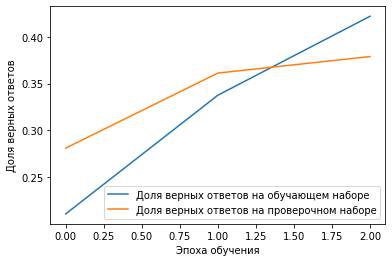

In [20]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [14]:
# Дополнительные домонстрационные модели

In [29]:
# Сеть LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(16))
model_lstm.add(Dense(nb_classes, activation='softmax'))

In [30]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [31]:
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                170       
Total params: 323,306
Trainable params: 323,306
Non-trainable params: 0
_________________________________________________________________


In [39]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [40]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 2.0289 - accuracy: 0.2019
Epoch 00001: val_accuracy improved from -inf to 0.20600, saving model to best_model_lstm.h5
176/176 [==============================] - 12s 68ms/step - loss: 2.0289 - accuracy: 0.2019 - val_loss: 2.0233 - val_accuracy: 0.2060
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 2.0288 - accuracy: 0.2020
Epoch 00002: val_accuracy did not improve from 0.20600
176/176 [==============================] - 12s 66ms/step - loss: 2.0288 - accuracy: 0.2020 - val_loss: 2.0246 - val_accuracy: 0.1920
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 2.0283 - accuracy: 0.2031
Epoch 00003: val_accuracy did not improve from 0.20600
176/176 [==============================] - 12s 70ms/step - loss: 2.0283 - accuracy: 0.2031 - val_loss: 2.0230 - val_accuracy: 0.2060
Epoch 4/5
176/176 [==============================] - ETA: 0s - loss: 2.0283 - accuracy: 0.2010
Epoch 00004: val_ac

In [ ]:
# Сеть GRU

In [35]:
model_gru = Sequential()
model_gru.add(Embedding(num_words, 32, input_length=max_news_len))
model_gru.add(GRU(16))
model_gru.add(Dense(nb_classes, activation='softmax'))

In [36]:
model_gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [38]:
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
gru (GRU)                    (None, 16)                2400      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
Total params: 322,570
Trainable params: 322,570
Non-trainable params: 0
_________________________________________________________________


In [41]:
model_gru_save_path = 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [42]:
history_gru = model_gru.fit(x_train, 
                              y_train, 
                              epochs=5,
                              batch_size=128,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_gru])

Epoch 1/5
176/176 [==============================] - ETA: 0s - loss: 2.0940 - accuracy: 0.2005
Epoch 00001: val_accuracy improved from -inf to 0.20600, saving model to best_model_gru.h5
176/176 [==============================] - 14s 80ms/step - loss: 2.0940 - accuracy: 0.2005 - val_loss: 2.0318 - val_accuracy: 0.2060
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 2.0316 - accuracy: 0.2000
Epoch 00002: val_accuracy did not improve from 0.20600
176/176 [==============================] - 14s 78ms/step - loss: 2.0316 - accuracy: 0.2000 - val_loss: 2.0241 - val_accuracy: 0.1920
Epoch 3/5
176/176 [==============================] - ETA: 0s - loss: 2.0300 - accuracy: 0.2035
Epoch 00003: val_accuracy did not improve from 0.20600
176/176 [==============================] - 12s 70ms/step - loss: 2.0300 - accuracy: 0.2035 - val_loss: 2.0233 - val_accuracy: 0.2060
Epoch 4/5
176/176 [==============================] - ETA: 0s - loss: 2.0293 - accuracy: 0.2020
Epoch 00004: val_acc

In [21]:
# Тестирование работы

In [44]:
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

In [45]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [46]:
y_test = utils.to_categorical(test_df['grade'] - 1, nb_classes)

In [47]:
# Качество Одномерная сверточная сеть

In [48]:
from tensorflow import keras
model_categorical = keras.models.load_model('model_categorical')
model_categorical_save_path = 'best_model_categorical.h5'
model_categorical.load_weights(model_categorical_save_path)

In [49]:
# Определение доли верных ответов на тестовом наборе
model_categorical.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 46s 59ms/step - loss: 2.1828 - accuracy: 0.2000


[2.1828248500823975, 0.19995999336242676]

In [50]:
model_lstm.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 8s 10ms/step - loss: 2.0244 - accuracy: 0.2009


[2.0243635177612305, 0.2008800059556961]

In [51]:
model_gru.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 8s 10ms/step - loss: 2.0256 - accuracy: 0.2009


[2.0255818367004395, 0.2008800059556961]

In [30]:
# Оцениваем тональность на собственном отзыве
# Загрузка обученного tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [31]:
text = """
good
"""

In [32]:
sequence = tokenizer.texts_to_sequences([text])

In [33]:
data = pad_sequences(sequence, maxlen=max_news_len)

In [35]:
result = list(model_categorical.predict(data)[0])

In [36]:
print('Кол-во звезд отзыва', result.index(max(result)) + 1)

Кол-во звезд отзыва 10


In [37]:
if result.index(max(result)) < 5:
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')

Отзыв положительный
